# Capstone Project - DermaSeer

At this stage, the process of loading, splitting, and pre-processing the dataset is carried out. Please note that after loading the dataset, the process of splitting the dataset will be carried out into 80% training data, 15% validation data, and 5% testing data. Then, data pre-processing will be carried out, including resizing, augmentation, and normalization for training and validation data. No pre-processing is carried out on testing data.

# 1. Import Library

In [1]:
import os  # interacting with the operating system (file and directory manipulation)
from PIL import Image  # image processing (open, manipulate, and save images)
import matplotlib.pyplot as plt  # data visualization (plotting graphs and charts)
import random  # random number generation and sampling
import shutil  # high-level file operations (copying, moving, deleting files)
from collections import defaultdict  # dictionary with default values for missing keys
from torchvision import transforms  # image transformations (for machine learning and data augmentation)

# 2. Load Dataset

The dataset is obtained from kaggle with the link: https://www.kaggle.com/datasets/dinartas/skin90?resource=download. With a focus on acne detection, data was taken from 5 types of acne, including Nodules, Phlegmona, Papules, Fungal, Pustules.
With information on the type of acne:
- N: Nodules - Acne in the form of hard lumps that form under the surface of the skin.
- F: Phlegmona - Acne that develops into a larger and more severe purulent infection.
- PA: Papules - Small red pimples that appear on the skin without pus.
- FU: Fungal - Large, inflamed pimples that occur due to bacterial infections in hair follicles.
- P: Pustules - Pimples filled with pus that appear on the surface of the skin, often with white or yellow heads.

In [2]:
# path to the folder containing images
folder_path = 'dataset-acne'

# initialize lists to store images and filenames
data = []
filenames = []

# loop to read each image file in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.jpg', '.JPG', '.png', '.jfif')):  # filter for image files
        file_path = os.path.join(folder_path, filename)
        
        # open the image and append it to the data list
        img = Image.open(file_path)
        data.append(img)
        
        # append the filename to the filenames list
        filenames.append(filename)
        
print('Number Of Images Loaded:', len(data))

Number Of Images Loaded: 350


In [3]:
# display all filename
for file in filenames:
    print(file)

f43.JPG
f57.JPG
pa34.jpg
pa20.JPG
fu63.JPG
p12.jpg
n62.JPG
n63.JPG
fu62.JPG
pa21.JPG
pa35.jpg
f56.JPG
f42.JPG
f54.JPG
f40.JPG
f68.JPG
pa23.JPG
pa37.jpg
fu48.JPG
fu60.JPG
p11.jpg
p39.JPG
p14.jfif
n49.JPG
n61.JPG
n60.JPG
n48.JPG
p38.JPG
p10.jpg
fu61.JPG
fu49.JPG
pa36.JPG
pa22.JPG
f69.JPG
f41.JPG
f55.JPG
f51.JPG
f45.JPG
n9.JPG
pa26.JPG
pa32.JPG
fu65.JPG
fu59.JPG
p28.jpg
n64.JPG
n70.JPG
n58.JPG
n59.JPG
n65.JPG
p15.JPG
p29.jpg
fu58.JPG
fu70.JPG
fu64.JPG
pa33.JPG
pa27.JPG
n8.JPG
f44.JPG
f50.JPG
f46.JPG
f52.JPG
pa19.JPG
fu8.JPG
pa31.JPG
pa25.jpg
fu66.JPG
p17.JPG
n67.JPG
n66.JPG
p16.JPG
fu67.JPG
pa24.JPG
pa30.JPG
fu9.JPG
pa18.JPG
f53.JPG
f47.JPG
f20.JPG
f34.JPG
f7.JPG
pa57.JPG
pa43.jpg
fu28.JPG
p45.jfif
fu14.JPG
p65.JPG
p59.JPG
pa6.JPG
n29.JPG
n15.JPG
n14.JPG
n28.JPG
pa7.JPG
p58.JPG
p70.JPG
p64.JPG
fu15.JPG
fu29.JPG
pa42.JPG
pa56.JPG
f6.JPG
f35.JPG
f21.JPG
f37.JPG
f23.JPG
f4.JPG
pa40.JPG
pa54.JPG
pa68.JPG
fu17.JPG
p66.JPG
pa5.jpg
n16.JPG
n17.JPG
pa4.JPG
p67.JPG
fu16.JPG
pa69.jpg
pa55.JPG
pa41.

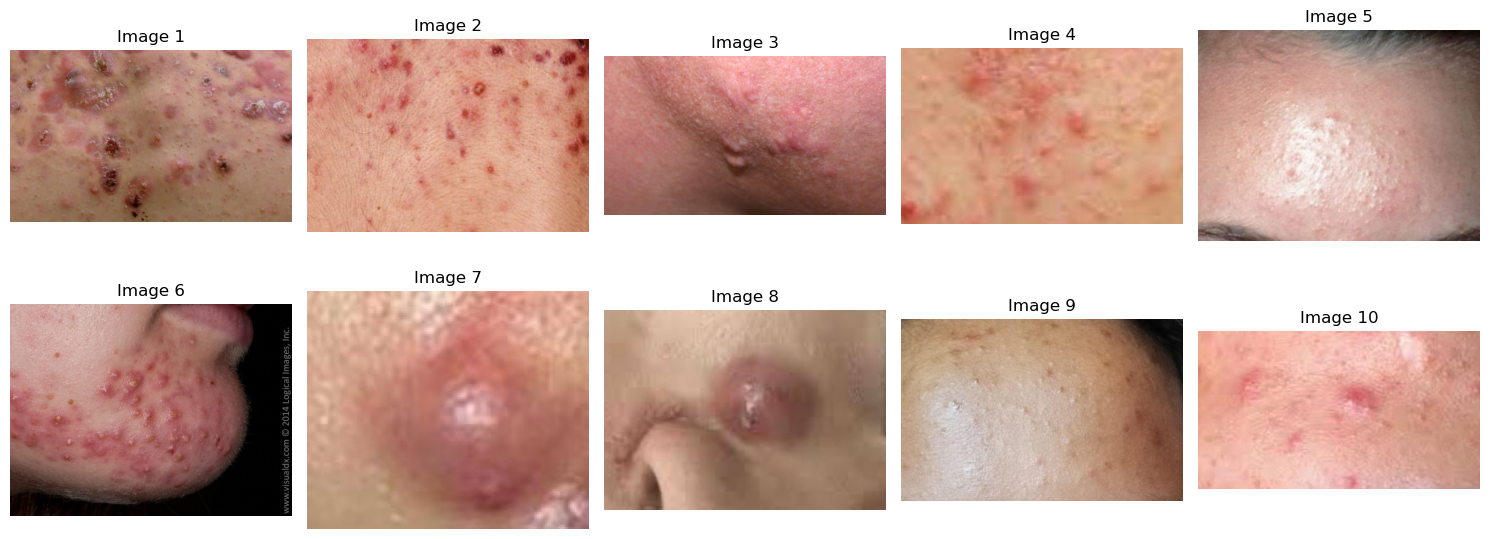

In [4]:
# display the top 10 images
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) 
for i, ax in enumerate(axes.flatten()[:10]): 
    # open the image file
    img_path = os.path.join(folder_path, filenames[i])
    img = Image.open(img_path)
    
    ax.imshow(img)
    ax.axis('off')  
    ax.set_title(f'Image {i+1}')  
    
plt.tight_layout()
plt.show()

# 3. Splitting Dataset

Splitting the dataset from each class/type of acne was done. With a proportion of 75% training data, 15% validation data, and 10% testing data.

In [5]:
# dataset split percentages
train_percentage = 0.75  # train data 75%
val_percentage = 0.15    # validation data 15%
test_percentage = 0.10   # test data 10%

# directories for each dataset
directories = {
    'train': 'train',
    'validation': 'validation',
    'test': 'test'}

# folder where the original images are stored (dataset-acne)
dataset_folder = 'dataset-acne'  

# create directories 
for folder in directories.values():
    os.makedirs(folder, exist_ok=True)

# organize images by class (label taken from the text after the last underscore)
class_dict = defaultdict(list)
for image in os.listdir(dataset_folder):
    if image.endswith(('.jpg', '.JPG', '.png', '.jfif')):  # only image files are processed
        # get the text after the last underscore
        label_part = image.split('_')[-1]
        
        # check if the second character is a digit; if so, only take the first character
        if len(label_part) > 1 and label_part[1].isdigit():
            label = label_part[0]  # only take the first character
        else:
            label = label_part[:2]  # take the first two characters if both are letters
            
        class_dict[label].append(image)

# split the images by class and count the number for each category
split_counts = {
    'train': defaultdict(int),
    'validation': defaultdict(int),
    'test': defaultdict(int)
}

# function to copy images to the appropriate folder
def copy_images(image_list, source_folder, destination_folder, class_name):
    # create sub-folder for the class name
    class_folder = os.path.join(destination_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)
    
    # copy images to the class folder
    for image in image_list:
        shutil.copy(os.path.join(source_folder, image), os.path.join(class_folder, image))

# process the split and copy the images
for label, images in class_dict.items():
    random.shuffle(images)
    
    total_images = len(images)
    train_count = int(train_percentage * total_images)
    val_count = int(val_percentage * total_images)
    test_count = total_images - train_count - val_count

    # split the images for each dataset
    splits = {
        'train': images[:train_count],
        'validation': images[train_count:train_count + val_count],
        'test': images[train_count + val_count:]
    }

    # copy the images to the respective folders and count the numbers
    for split, image_list in splits.items():
        copy_images(image_list, dataset_folder, directories[split], label)
        split_counts[split][label] = len(image_list)

# output the results of the dataset split
print(f'Dataset Split Completed')
for split in ['train', 'validation', 'test']:
    print(f'\n{split.capitalize()}:')
    print(f'Total Number of Images: {sum(split_counts[split].values())}')
    for label, count in split_counts[split].items():
        print(f'{label.upper()}: {count} ({(count / sum(split_counts[split].values())) * 100:.2f}%)')

Dataset Split Completed

Train:
Total Number of Images: 260
F: 52 (20.00%)
PA: 52 (20.00%)
FU: 52 (20.00%)
P: 52 (20.00%)
N: 52 (20.00%)

Validation:
Total Number of Images: 50
F: 10 (20.00%)
PA: 10 (20.00%)
FU: 10 (20.00%)
P: 10 (20.00%)
N: 10 (20.00%)

Test:
Total Number of Images: 40
F: 8 (20.00%)
PA: 8 (20.00%)
FU: 8 (20.00%)
P: 8 (20.00%)
N: 8 (20.00%)


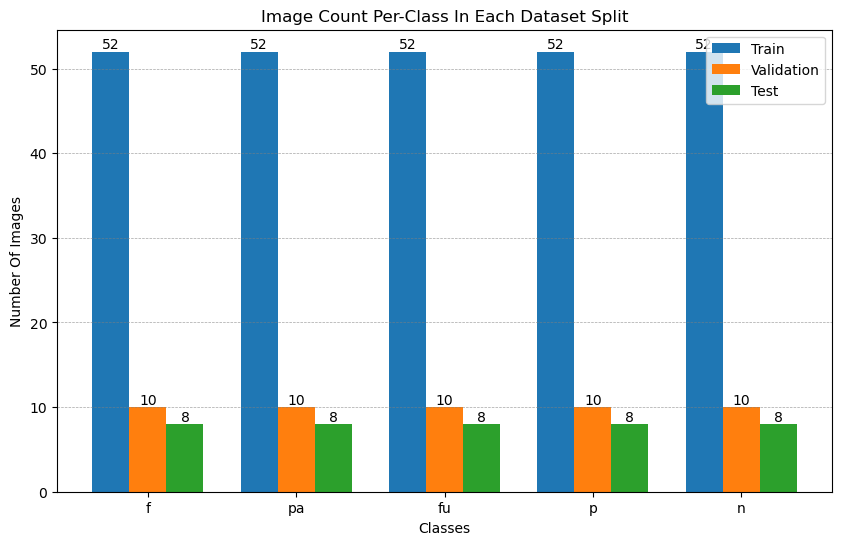

In [6]:
# prepare data for visualization
splits = ['train', 'validation', 'test']
classes = list(split_counts['train'].keys())
split_data = {split: [split_counts[split][cls] for cls in classes] for split in splits}

# plot the data
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25  # width of each bar
x = range(len(classes))

# plot each split as a separate bar group and add text on top of each bar
for i, split in enumerate(splits):
    bars = ax.bar([pos + i * width for pos in x], split_data[split], width, label=split.capitalize())
    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval}', ha='center', va='bottom')

# add a grid background
ax.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# configure the plot
ax.set_xticks([pos + width for pos in x])
ax.set_xticklabels(classes)
ax.set_xlabel('Classes')
ax.set_ylabel('Number Of Images')
ax.set_title('Image Count Per-Class In Each Dataset Split')
ax.legend()

plt.show()

# 4. Pre-Processing Dataset

Pre-processing of the dataset was carried out with the stages of resizing images, augmentation, and also normalization for training data and validation data only.

**A. Resize Images**

In [7]:
# setup resize images
resize_shape = (224, 224)  # the target size for resizing images

# define the main folder for resized images
main_resize_folder = 'resize-images'  # main folder for resized images

# define subfolders for train and validation datasets
resize_train_folder = os.path.join(main_resize_folder, 'resize-train')  # output folder for resized training images
resize_validation_folder = os.path.join(main_resize_folder, 'resize-validation')  # output folder for resized validation images

# create the main resize folder and subfolders if they don't exist
os.makedirs(resize_train_folder, exist_ok=True)
os.makedirs(resize_validation_folder, exist_ok=True)

# initialize list to store resized image paths
resized_images = []

# define the source folders for train and validation datasets
folders = ['train', 'validation']
base_path = '.'  # current directory

# loop through each folder (train and validation)
for folder in folders:
    folder_path = os.path.join(base_path, folder)  # get full path of train/validation
    if os.path.exists(folder_path):
        print(f"Processing Folder: {folder_path}")
        
        # loop through the directory tree using os.walk
        for root, dirs, files in os.walk(folder_path):
            print(f"Processing Directory: {root}")
            # loop through files in each subdirectory
            for filename in files:
                # check if the file is an image
                name, ext = os.path.splitext(filename)
                if ext.lower() in ['.jpg', '.jpeg', '.png', '.jfif']:  # check for image extensions
                    file_path = os.path.join(root, filename)  # full path of the image
                    try:
                        # open the image and resize it
                        img = Image.open(file_path)
                        img = img.resize(resize_shape)
                        
                        # construct the path to save the resized image
                        if folder == 'train':
                            resized_image_path = os.path.join(resize_train_folder, f"resized_{filename}")
                        else:  # folder == 'validation'
                            resized_image_path = os.path.join(resize_validation_folder, f"resized_{filename}")
                        
                        # save the resized image
                        img.save(resized_image_path)
                        resized_images.append(resized_image_path)
                        print(f"Saved Resized Image To: {resized_image_path}")
                    except Exception as e:
                        print(f"failed to process {file_path}: {e}")
                else:
                    print(f"Skipping Non-Image File: {filename}")
    else:
        print(f"Folder {folder} Not Found At Path: {folder_path}")

# print out the resized images
print("Resized Images:", resized_images)

Processing Folder: ./train
Processing Directory: ./train
Processing Directory: ./train/n
Saved Resized Image To: resize-images/resize-train/resized_n62.JPG
Saved Resized Image To: resize-images/resize-train/resized_n63.JPG
Saved Resized Image To: resize-images/resize-train/resized_n49.JPG
Saved Resized Image To: resize-images/resize-train/resized_n48.JPG
Saved Resized Image To: resize-images/resize-train/resized_n9.JPG
Saved Resized Image To: resize-images/resize-train/resized_n64.JPG
Saved Resized Image To: resize-images/resize-train/resized_n70.JPG
Saved Resized Image To: resize-images/resize-train/resized_n59.JPG
Saved Resized Image To: resize-images/resize-train/resized_n65.JPG
Saved Resized Image To: resize-images/resize-train/resized_n8.JPG
Saved Resized Image To: resize-images/resize-train/resized_n67.JPG
Saved Resized Image To: resize-images/resize-train/resized_n66.JPG
Saved Resized Image To: resize-images/resize-train/resized_n29.JPG
Saved Resized Image To: resize-images/resi

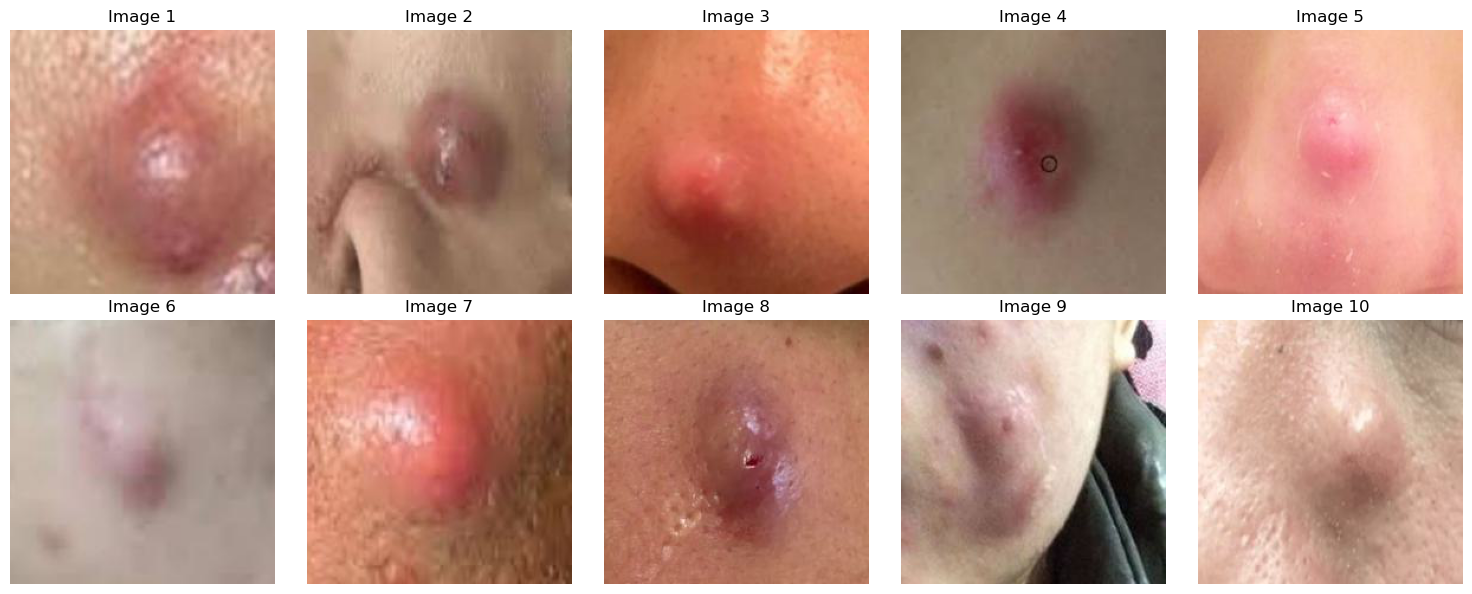

In [8]:
# display the first 10 resized images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()[:10]):
    ax.imshow(Image.open(resized_images[i]))
    ax.axis('off')
    ax.set_title(f'Image {i+1}')
plt.tight_layout()
plt.show()

**B. Augmentation Images**

In [15]:
# folder paths
resize_folder = 'resize-images'  # main folder for resized images
augmentation_folder = 'augmentation-images'  # main folder for augmented images

# create the main augmentation folder if it doesn't exist
os.makedirs(augmentation_folder, exist_ok=True)

# create the subfolders for train and validation if they don't exist
augmentation_train_folder = os.path.join(augmentation_folder, 'augmentation-train')
augmentation_validation_folder = os.path.join(augmentation_folder, 'augmentation-validation')

os.makedirs(augmentation_train_folder, exist_ok=True)
os.makedirs(augmentation_validation_folder, exist_ok=True)

# define the augmentation pipeline
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # augment: random horizontal flip
    transforms.RandomVerticalFlip(),    # augment: random vertical flip
    transforms.RandomRotation(30),      # augment: random rotation up to 30 degrees
    transforms.RandomResizedCrop(128),  # augment: random crop and resize to 128x128
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # augment: random color jitter
    transforms.ToTensor(),              # convert image to tensor
])

# process all images in the 'resize-images' folder
for subfolder in ['resize-train', 'resize-validation']:
    folder_path = os.path.join(resize_folder, subfolder)  # get full path of resize-train or resize-validation
    if os.path.exists(folder_path):
        print(f"Processing Folder: {folder_path}")
        
        # loop through files in each subfolder
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.JPG', '.png', '.jfif')):  
                img_path = os.path.join(folder_path, filename)
                
                # open the image
                img = Image.open(img_path)
                
                # generate and save 5 augmented images for each image
                augmented_images = []
                for i in range(5):
                    augmented_img = transform(img)
                    
                    # convert back to PIL image for saving
                    augmented_img_pil = transforms.ToPILImage()(augmented_img)
                    
                    # define the path to save the augmented image
                    if subfolder == 'resize-train':
                        augmented_image_path = os.path.join(augmentation_train_folder, f"Augmented_{i}_{filename}")
                    else:  # subfolder == 'resize-validation'
                        augmented_image_path = os.path.join(augmentation_validation_folder, f"Augmented_{i}_{filename}")
                    
                    # save the augmented image
                    augmented_img_pil.save(augmented_image_path)
                    
                    # add to the list of augmented images
                    augmented_images.append(augmented_img_pil)

                print(f'Augmentation For {filename} Completed. Total {len(augmented_images)} Images Saved.')

print('Augmentation For All Images Completed.')

Processing Folder: resize-images/resize-train
Augmentation For resized_fu32.JPG Completed. Total 5 Images Saved.
Augmentation For resized_f28.JPG Completed. Total 5 Images Saved.
Augmentation For resized_n21.JPG Completed. Total 5 Images Saved.
Augmentation For resized_pa59.JPG Completed. Total 5 Images Saved.
Augmentation For resized_p44.JPG Completed. Total 5 Images Saved.
Augmentation For resized_p50.jpg Completed. Total 5 Images Saved.
Augmentation For resized_pa58.JPG Completed. Total 5 Images Saved.
Augmentation For resized_n20.JPG Completed. Total 5 Images Saved.
Augmentation For resized_pa64.JPG Completed. Total 5 Images Saved.
Augmentation For resized_pa70.JPG Completed. Total 5 Images Saved.
Augmentation For resized_f29.JPG Completed. Total 5 Images Saved.
Augmentation For resized_fu27.JPG Completed. Total 5 Images Saved.
Augmentation For resized_fu33.JPG Completed. Total 5 Images Saved.
Augmentation For resized_fu19.JPG Completed. Total 5 Images Saved.
Augmentation For resiz

**C. Normalization Images**

In [16]:
# folder paths
augmentation_folder = 'augmentation-images'  # folder for augmented images
normalized_folder = 'normalization-images'  # folder for normalized images

# create the main normalization folder if it doesn't exist
os.makedirs(normalized_folder, exist_ok=True)

# create the subfolders for normalization-train and normalization-validation if they don't exist
normalization_train_folder = os.path.join(normalized_folder, 'normalization-train')
normalization_validation_folder = os.path.join(normalized_folder, 'normalization-validation')

os.makedirs(normalization_train_folder, exist_ok=True)
os.makedirs(normalization_validation_folder, exist_ok=True)

# define the normalization transformation to the range [0, 1]
normalize_transform = transforms.Compose([
    transforms.ToTensor(),  # convert the image to a tensor with the range [0, 1]
])

# process all images in the 'augmentation-images' folder
for subfolder in ['augmentation-train', 'augmentation-validation']:  # adjust subfolders for augmentation
    folder_path = os.path.join(augmentation_folder, subfolder)  # get full path of the subfolder
    if os.path.exists(folder_path):
        print(f"Processing Folder: {folder_path}")

        # loop through files in each subfolder
        for filename in os.listdir(folder_path):
            if filename.endswith(('.jpg', '.JPG', '.png', '.jfif')):  # check if the file is an image
                img_path = os.path.join(folder_path, filename)

                # open the image
                img = Image.open(img_path)

                # apply normalization
                img_normalized = normalize_transform(img)  # the image is now in tensor format with the range [0, 1]

                # check the tensor values
                print(f'Image {filename}: Min = {img_normalized.min()}, Max = {img_normalized.max()}')  # should be Min = 0.0 and Max = 1.0

                # convert back to PIL image to save
                img_normalized_pil = transforms.ToPILImage()(img_normalized)

                # define the path to save the normalized image
                if subfolder == 'augmentation-train':
                    normalized_image_path = os.path.join(normalization_train_folder, f'Normalized_{filename}')
                else:  # subfolder == 'augmentation-validation'
                    normalized_image_path = os.path.join(normalization_validation_folder, f'Normalized_{filename}')

                # save the normalized image
                img_normalized_pil.save(normalized_image_path)

        print(f'Normalization Completed For {subfolder}.')

print('Normalization For All Images Completed.')

Processing Folder: augmentation-images/augmentation-train
Image Augmented_1_resized_n48.JPG: Min = 0.0, Max = 0.729411780834198
Image Augmented_4_resized_pa63.JPG: Min = 0.0, Max = 1.0
Image Augmented_2_resized_fu64.JPG: Min = 0.0, Max = 1.0
Image Augmented_2_resized_fu70.JPG: Min = 0.6039215922355652, Max = 0.8901960849761963
Image Augmented_1_resized_p10.jpg: Min = 0.0, Max = 1.0
Image Augmented_4_resized_f65.JPG: Min = 0.08235294371843338, Max = 0.9450980424880981
Image Augmented_3_resized_f61.JPG: Min = 0.12156862765550613, Max = 1.0
Image Augmented_4_resized_f59.JPG: Min = 0.0, Max = 1.0
Image Augmented_1_resized_p38.JPG: Min = 0.43921568989753723, Max = 1.0
Image Augmented_2_resized_n25.JPG: Min = 0.0, Max = 0.7098039388656616
Image Augmented_0_resized_fu18.JPG: Min = 0.0, Max = 0.9960784316062927
Image Augmented_2_resized_n31.JPG: Min = 0.0, Max = 1.0
Image Augmented_2_resized_n19.JPG: Min = 0.21176470816135406, Max = 1.0
Image Augmented_0_resized_fu24.JPG: Min = 0.0, Max = 0.83

In [17]:
# folder path
normalization_folder = 'normalization-images'

# function to count image files in a directory
def count_images_in_folder(folder_path):
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg', '.JPG', '.png', '.jfif')):  # check for image files
                image_count += 1
    return image_count

# count images in normalization-train and normalization-validation subfolders
normalization_train_folder = os.path.join(normalization_folder, 'normalization-train')
normalization_validation_folder = os.path.join(normalization_folder, 'normalization-validation')

# count the images
train_image_count = count_images_in_folder(normalization_train_folder)
validation_image_count = count_images_in_folder(normalization_validation_folder)

# print the counts
print(f"Number Of Images In 'Normalization Train': {train_image_count}")
print(f"Number Of Images In 'Normalization Validation': {validation_image_count}")
print(f"Total Number Of Images In 'Normalization Images': {train_image_count + validation_image_count}")

Number Of Images In 'Normalization Train': 1300
Number Of Images In 'Normalization Validation': 250
Total Number Of Images In 'Normalization Images': 1550
